In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


# Cargar el archivo de texto en un DataFrame
df = pd.read_csv('sell-in.txt.gz', sep='\t')


In [2]:
df.head()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn
0,201701,10234,20524,0,2,0.05300,0.05300
1,201701,10032,20524,0,1,0.13628,0.13628
2,201701,10217,20524,0,1,0.03028,0.03028
3,201701,10125,20524,0,1,0.02271,0.02271
4,201701,10012,20524,0,11,1.54452,1.54452


In [3]:
df.columns

Index(['periodo', 'customer_id', 'product_id', 'plan_precios_cuidados',
       'cust_request_qty', 'cust_request_tn', 'tn'],
      dtype='object')

In [4]:
productos = pd.read_csv('tb_productos.txt', sep='\t')

In [5]:
productos.head()

,cat1,cat2,cat3,brand,sku_size,product_id
0,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20280
1,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20180
2,HC,ROPA LAVADO,Liquido,LIMPIEX,120,20332
3,HC,ROPA LAVADO,Liquido,LIMPIEX,450,20222
4,HC,ROPA LAVADO,Liquido,LIMPIEX,900,20288


Se hace una unión de los datasets

In [6]:
df_merged = pd.merge(df, productos, on='product_id', how='left')

In [7]:
stocks = pd.read_csv('tb_stocks.txt.gz', sep='\t')

In [8]:
stocks.head()

,periodo,product_id,stock_final
0,201810,20524,1.61267
1,201810,20311,2.93657
2,201810,20654,6.83269
3,201810,21005,1.01338
4,201810,20974,0.34595


In [9]:
df_final = pd.merge(df_merged, stocks, on=['periodo', 'product_id'], how='left')

In [10]:

df_final['periodo'] = pd.to_datetime(df['periodo'])
df_final.set_index('periodo', inplace=True)


In [17]:
df_final.head()

,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,stock_final,cluster
periodo,,,,,,,,,,,,,
1970-01-01 00:00:00.000201701,10234,20524,0,2,0.05300,0.05300,HC,VAJILLA,Cristalino,Importado,500.0,NaN,0
1970-01-01 00:00:00.000201702,10150,20669,0,1,0.03660,0.03660,PC,CABELLO,ACONDICIONADOR,SHAMPOO1,200.0,NaN,0
1970-01-01 00:00:00.000201703,10012,20572,0,1,0.01579,0.01579,PC,CABELLO,SHAMPOO,SHAMPOO1,200.0,NaN,0
1970-01-01 00:00:00.000201704,10407,20452,0,1,0.03250,0.03250,PC,DEOS,Aero,COLBERT,100.0,NaN,0
1970-01-01 00:00:00.000201705,10153,20009,0,1,0.61261,0.61261,HC,ROPA LAVADO,Liquido,ROPEX1,3000.0,NaN,1


Comprobacion de la integridad de los datos

In [11]:
# Verificar valores faltantes
print(df_final.isnull().sum())

# Identificar valores atípicos
for columna in df_final.select_dtypes(include=['number']).columns:
    q1 = df_final[columna].quantile(0.25)
    q3 = df_final[columna].quantile(0.75)
    rango_intercuartil = q3 - q1
    valores_atipicos = df_final[(df_final[columna] < q1 - 1.5 * rango_intercuartil) | (df_final[columna] > q3 + 1.5 * rango_intercuartil)]
    print(f"Valores atípicos en {columna}: {valores_atipicos.shape[0]}")

customer_id                    0
product_id                     0
plan_precios_cuidados          0
cust_request_qty               0
cust_request_tn                0
tn                             0
cat1                        7448
cat2                        7448
cat3                        7448
brand                       7448
sku_size                    7448
stock_final              1839319
dtype: int64
Valores atípicos en customer_id: 6415
Valores atípicos en product_id: 0
Valores atípicos en plan_precios_cuidados: 34029
Valores atípicos en cust_request_qty: 318215
Valores atípicos en cust_request_tn: 444119
Valores atípicos en tn: 442925
Valores atípicos en sku_size: 173612
Valores atípicos en stock_final: 128207


Análisis exploratorio de variables

In [12]:

import seaborn as sns

# Estadísticas descriptivas para variables numéricas
print(df_final.describe())


        customer_id    product_id  plan_precios_cuidados  cust_request_qty  \
count  2.988650e+06  2.988650e+06           2.988650e+06      2.988650e+06   
mean   1.017140e+04  2.042319e+04           1.138608e-02      2.149502e+00   
std    1.420396e+02  3.129415e+02           1.060964e-01      3.580576e+00   
min    1.000100e+04  2.000100e+04           0.000000e+00      1.000000e+00   
25%    1.005300e+04  2.015500e+04           0.000000e+00      1.000000e+00   
50%    1.013300e+04  2.036000e+04           0.000000e+00      1.000000e+00   
75%    1.026700e+04  2.065000e+04           0.000000e+00      2.000000e+00   
max    1.063700e+04  2.129900e+04           1.000000e+00      9.200000e+01   

       cust_request_tn            tn      sku_size   stock_final  
count     2.988650e+06  2.988650e+06  2.981202e+06  1.149331e+06  
mean      4.769105e-01  4.668406e-01  4.452770e+02  2.713918e+01  
std       3.276818e+00  3.159888e+00  7.411227e+02  7.475098e+01  
min       1.000000e-04  1.000

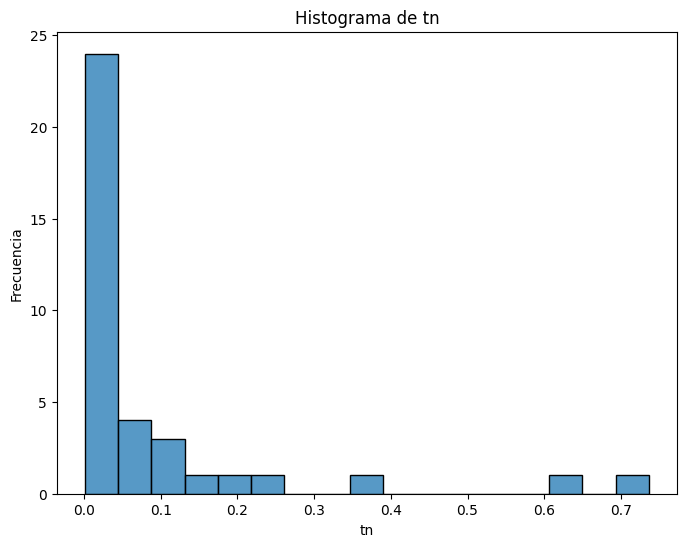

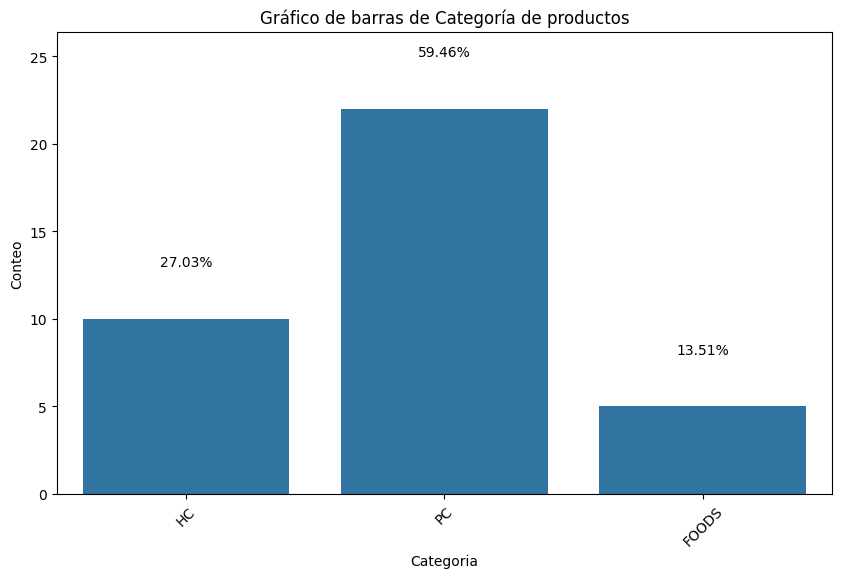

In [13]:
df_final = df_final[~df_final.index.duplicated(keep='first')]


# Histograma para una variable numérica
plt.figure(figsize=(8, 6))
sns.histplot(data=df_final, x='tn')
plt.title('Histograma de tn')  # Título del gráfico
plt.xlabel('tn')  # Etiqueta del eje x
plt.ylabel('Frecuencia')  # Etiqueta del eje y
plt.show()

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='cat1', data=df_final)
plt.title('Gráfico de barras de Categoría de productos')  # Título del gráfico
plt.xlabel('Categoria')  # Etiqueta del eje x
plt.ylabel('Conteo')  # Etiqueta del eje y
plt.xticks(rotation=45)

total = len(df_final)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center") 

# Ajusta los límites del eje y
ax.set_ylim(0, 1.2*df_final['cat1'].value_counts().max())

plt.show()

Análisis de relaciones

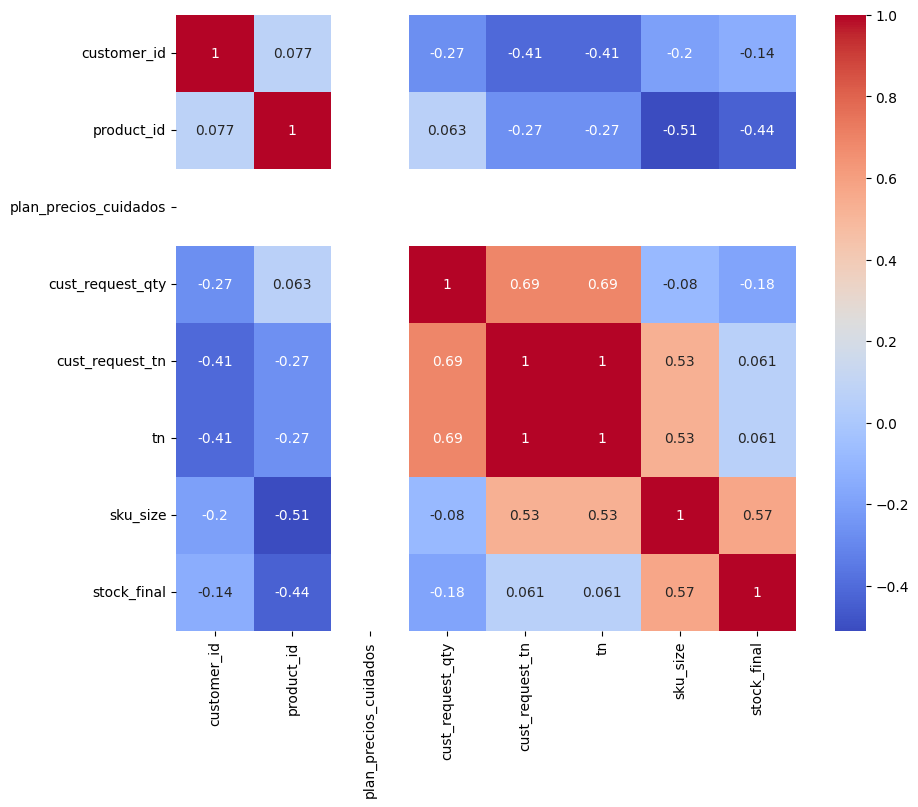

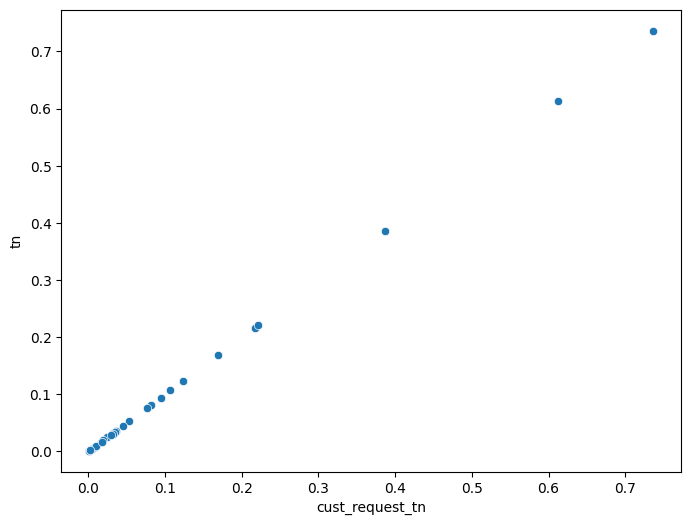

In [14]:
# Matriz de correlación
correlaciones = df_final.select_dtypes(include=['number']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm')
plt.show()

# Gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(x='cust_request_tn', y='tn', data=df_final)
plt.show()


Análisis de tendencia y estacionalidad

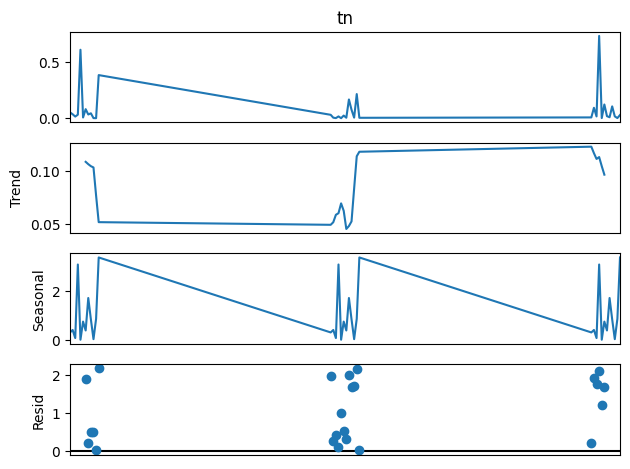

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Crear serie de tiempo de ventas totales
ventas_totales = df_final.groupby('periodo')['tn'].sum()

# Descomposición de la serie de tiempo
descomposicion = seasonal_decompose(ventas_totales, model='multiplicative', period=12)  # Periodo de 12 meses para estacionalidad anual

# Graficar componentes de la serie
descomposicion.plot()
plt.show()

c:\Users\marce\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\marce\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


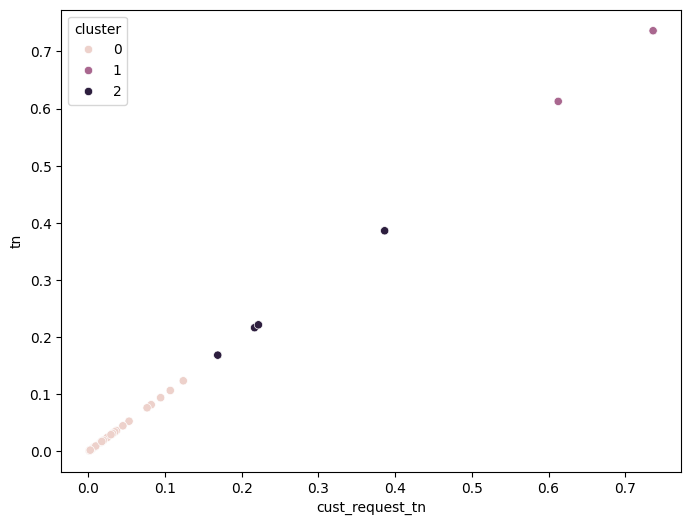

In [16]:
from sklearn.cluster import KMeans

# Seleccionar características relevantes
caracteristicas = df_final[['tn', 'cust_request_tn',]]

# Aplicar k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42).fit(caracteristicas)

# Agregar etiquetas de cluster a los datos
df_final['cluster'] = kmeans.labels_

# Visualizar clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='cust_request_tn', y='tn', data=df_final, hue='cluster')
plt.show()

Ventas por Categoría 1:
    cat1       tn
0  FOODS  0.20239
1     HC  1.55048
2     PC  1.50538


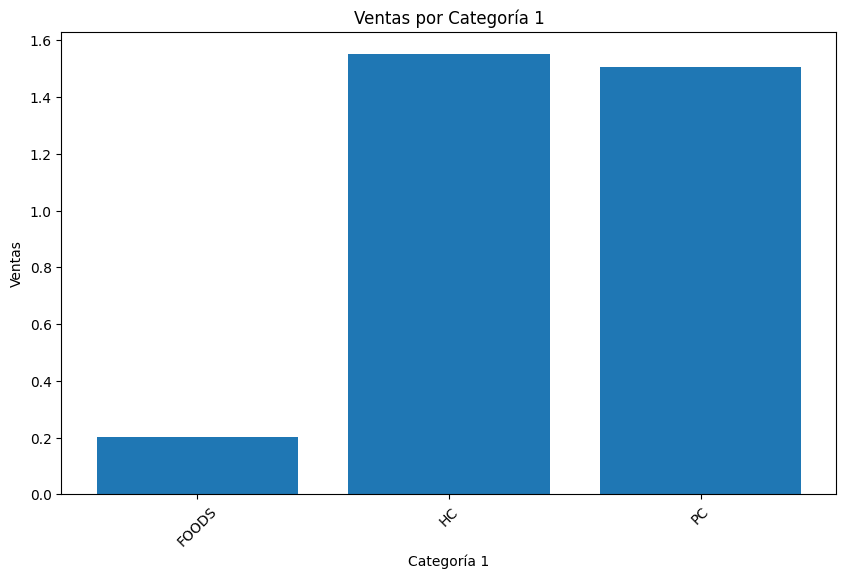


Ventas por Categoría 2:
                  cat2       tn
0             ADEREZOS  0.16860
1              CABELLO  0.33662
2                 DEOS  1.07402
3                HOGAR  0.15947
4                PIEL1  0.00218
5                PIEL2  0.09256
6  ROPA ACONDICIONADOR  0.00614
7          ROPA LAVADO  0.92847
8       SOPAS Y CALDOS  0.03379
9              VAJILLA  0.45640


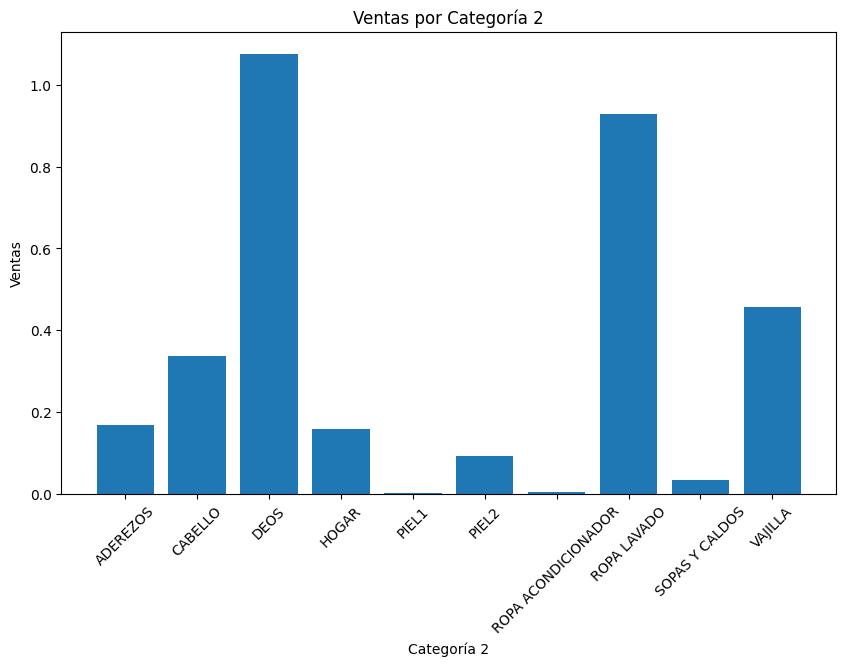


Ventas por Categoría 3:
              cat3       tn
0   ACONDICIONADOR  0.07551
1             Aero  1.03635
2           BARRAS  0.08190
3      Baking Bags  0.00239
4             Cara  0.00218
5      Concentrado  0.00614
6       Cristalino  0.05300
7            DETOX  0.01713
8              Gel  0.40340
9    Jabon Regular  0.00819
10        LIQUIDOS  0.00247
11         Liquido  0.92847
12        Mayonesa  0.16860
13          NoAero  0.01747
14           PISOS  0.12371
15          RollOn  0.00579
16         SHAMPOO  0.24398
17           Sopas  0.03140
18        TOILETTE  0.03576
19           Talco  0.01441


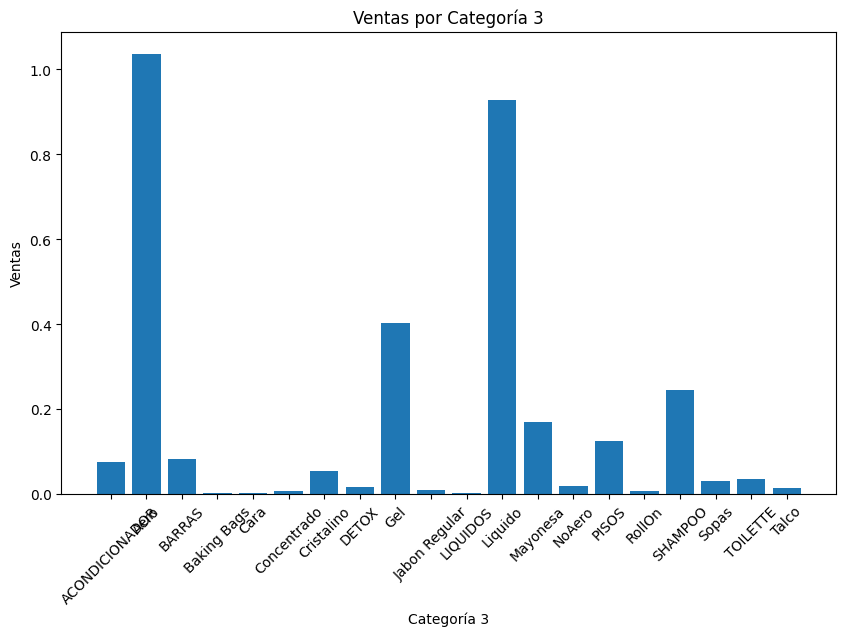


Ventas por Marca:
        brand       tn
0      AYUDIN  0.03576
1     COLBERT  0.06395
2       DEOS1  0.20867
3       DEOS3  0.95293
4     ESPADOL  0.00247
5   Importado  0.05300
6      JABON1  0.08190
7     LANCOME  0.00218
8     LIMPIEX  0.09418
9       MAGGI  0.03379
10    MUSCULO  0.52711
11      NIVEA  0.14884
12     ROPEX1  0.83429
13   SHAMPOO1  0.06952
14   SHAMPOO3  0.14352
15     VIVERE  0.00614


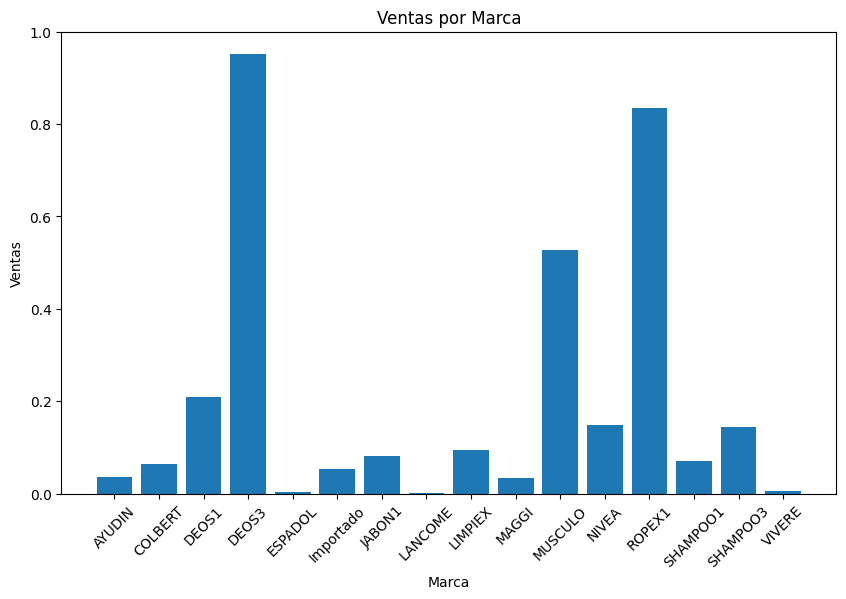


Ventas agrupadas por Categoría 1, Categoría 2 y Marca:
     cat1                 cat2      brand       tn
0   FOODS             ADEREZOS      DEOS1  0.16860
1   FOODS       SOPAS Y CALDOS      MAGGI  0.03379
2      HC                HOGAR     AYUDIN  0.03576
3      HC                HOGAR    MUSCULO  0.12371
4      HC  ROPA ACONDICIONADOR     VIVERE  0.00614
5      HC          ROPA LAVADO    LIMPIEX  0.09418
6      HC          ROPA LAVADO     ROPEX1  0.83429
7      HC              VAJILLA  Importado  0.05300
8      HC              VAJILLA    MUSCULO  0.40340
9      PC              CABELLO      NIVEA  0.12358
10     PC              CABELLO   SHAMPOO1  0.06952
11     PC              CABELLO   SHAMPOO3  0.14352
12     PC                 DEOS    COLBERT  0.06395
13     PC                 DEOS      DEOS1  0.03188
14     PC                 DEOS      DEOS3  0.95293
15     PC                 DEOS      NIVEA  0.02526
16     PC                PIEL1    LANCOME  0.00218
17     PC                P

In [18]:



# Agrupar las ventas (tn) por categoría 1
ventas_cat1 = df_final.groupby('cat1')['tn'].sum().reset_index()
print("Ventas por Categoría 1:")
print(ventas_cat1)

# Gráfico de ventas por categoría 1
plt.figure(figsize=(10, 6))
plt.bar(ventas_cat1['cat1'], ventas_cat1['tn'])
plt.xlabel('Categoría 1')
plt.ylabel('Ventas')
plt.title('Ventas por Categoría 1')
plt.xticks(rotation=45)
plt.show()

# Agrupar las ventas (tn) por categoría 2
ventas_cat2 = df_final.groupby('cat2')['tn'].sum().reset_index()
print("\nVentas por Categoría 2:")
print(ventas_cat2)

# Gráfico de ventas por categoría 2
plt.figure(figsize=(10, 6))
plt.bar(ventas_cat2['cat2'], ventas_cat2['tn'])
plt.xlabel('Categoría 2')
plt.ylabel('Ventas')
plt.title('Ventas por Categoría 2')
plt.xticks(rotation=45)
plt.show()

# Agrupar las ventas (tn) por categoría 3
ventas_cat3 = df_final.groupby('cat3')['tn'].sum().reset_index()
print("\nVentas por Categoría 3:")
print(ventas_cat3)

# Gráfico de ventas por categoría 3
plt.figure(figsize=(10, 6))
plt.bar(ventas_cat3['cat3'], ventas_cat3['tn'])
plt.xlabel('Categoría 3')
plt.ylabel('Ventas')
plt.title('Ventas por Categoría 3')
plt.xticks(rotation=45)
plt.show()

# Agrupar las ventas (tn) por marca
ventas_marca = df_final.groupby('brand')['tn'].sum().reset_index()
print("\nVentas por Marca:")
print(ventas_marca)

# Gráfico de ventas por marca
plt.figure(figsize=(10, 6))
plt.bar(ventas_marca['brand'], ventas_marca['tn'])
plt.xlabel('Marca')
plt.ylabel('Ventas')
plt.title('Ventas por Marca')
plt.xticks(rotation=45)
plt.show()

# Agrupar las ventas (tn) por categoría 1, categoría 2 y marca
ventas_agrupadas = df_final.groupby(['cat1', 'cat2', 'brand'])['tn'].sum().reset_index()
print("\nVentas agrupadas por Categoría 1, Categoría 2 y Marca:")
print(ventas_agrupadas)